In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the data
file_path = './research_paper_dataset.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()


,abstract,authors,n_citation,references,title,venue,year,id
0,"In this paper, a robust 3D triangular mesh wat...","['S. Ben Jabra', 'Ezzeddine Zagrouba']",50,"['09cb2d7d-47d1-4a85-bfe5-faa8221e644b', '10aa...",A new approach of 3D watermarking based on ima...,international symposium on computers and commu...,2008,4ab3735c-80f1-472d-b953-fa0557fed28b
1,We studied an autoassociative neural network w...,"['Joaquín J. Torres', 'Jesús M. Cortés', 'Joaq...",50,"['4017c9d2-9845-4ad2-ad5b-ba65523727c5', 'b118...",Attractor neural networks with activity-depend...,Neurocomputing,2007,4ab39729-af77-46f7-a662-16984fb9c1db
2,It is well-known that Sturmian sequences are t...,"['Genevi eve Paquin', 'Laurent Vuillon']",50,"['1c655ee2-067d-4bc4-b8cc-bc779e9a7f10', '2e4e...",A characterization of balanced episturmian seq...,Electronic Journal of Combinatorics,2007,4ab3a4cf-1d96-4ce5-ab6f-b3e19fc260de
3,One of the fundamental challenges of recognizi...,"['Yaser Sheikh', 'Mumtaz Sheikh', 'Mubarak Shah']",221,"['056116c1-9e7a-4f9b-a918-44eb199e67d6', '05ac...",Exploring the space of a human action,international conference on computer vision,2005,4ab3a98c-3620-47ec-b578-884ecf4a6206
4,This paper generalizes previous optimal upper ...,"['Efraim Laksman', 'Håkan Lennerstad', 'Magnus...",0,"['01a765b8-0cb3-495c-996f-29c36756b435', '5dbc...",Generalized upper bounds on the minimum distan...,Ima Journal of Mathematical Control and Inform...,2015,4ab3b585-82b4-4207-91dd-b6bce7e27c4e


In [3]:
data['abstract'] = data['abstract'].fillna('')
data['title'] = data['title'].fillna('')

# Combine title and abstract for text processing
data['text'] = data['title'].astype(str) + ' ' + data['abstract'].astype(str)

# Tokenize the text data
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])

# Pad the sequences
maxlen = 300  # Maximum length of sequences
X = pad_sequences(sequences, maxlen=maxlen)

# Prepare the target variable
y = data['n_citation'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_shape=(maxlen,)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 3957s 790ms/step - loss: 42457.8242 - val_loss: 39802.1094
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 3860s 772ms/step - loss: 29888.7852 - val_loss: 39584.2227
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 4297s 860ms/step - loss: 35240.3516 - val_loss: 39380.0938
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 3154s 631ms/step - loss: 34060.9727 - val_loss: 39255.8672
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 3194s 639ms/step - loss: 28336.0449 - val_loss: 39219.7031


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 522s 84ms/step
Mean Absolute Error: 36.5341725893414
Root Mean Squared Error: 186.62826772904592


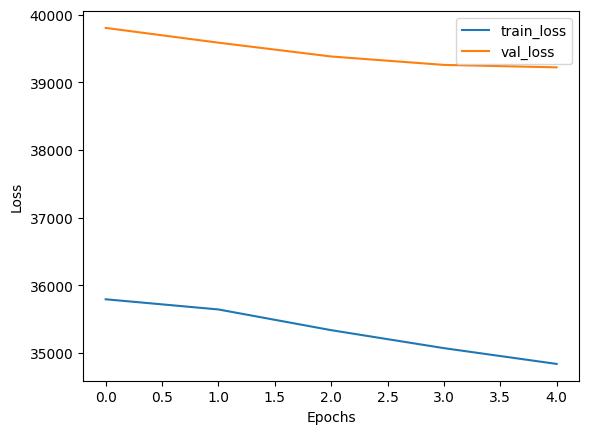

In [7]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

# Plot the training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

R-squared: 0.018681049346923828


In [15]:
# Test on a new abstract
import os
import pickle
test_abstract = "This paper introduces a novel approach to quantum computing..."
test_title = "Quantum Computing Advancements"
test_text = test_title + ' ' + test_abstract

# Preprocess the test abstract
test_sequence = tokenizer.texts_to_sequences([test_text])
test_padded = pad_sequences(test_sequence, maxlen=maxlen)

# Predict the citation count for the new abstract
predicted_citation = model.predict(test_padded)
print(f"Predicted Citation Count: {predicted_citation[0][0]}")

# Save the model and tokenizer to files
model_save_path = './citation_model.keras'
tokenizer_save_path = './tokenizer.pkl'

# Delete the existing model file if it exists
if os.path.exists(model_save_path):
    os.remove(model_save_path)

# Save the Keras model in the new format
model.save(model_save_path)

# Save the tokenizer
with open(tokenizer_save_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Citation Count: 15.985666275024414


In [13]:
# # Test on a new abstract
# import os
# test_abstract = "This paper introduces a novel approach to quantum computing..."
# test_title = "Quantum Computing Advancements"
# test_text = test_title + ' ' + test_abstract

# # Preprocess the test abstract
# test_sequence = tokenizer.texts_to_sequences([test_text])
# test_padded = pad_sequences(test_sequence, maxlen=maxlen)

# # Predict the citation count for the new abstract
# predicted_citation = model.predict(test_padded)
# print(f"Predicted Citation Count: {predicted_citation[0][0]}")

# # Save the model and tokenizer to files
# model_save_path = './citation_model.h5'
# tokenizer_save_path = './tokenizer.pkl'

# # Delete the existing model file if it exists
# if os.path.exists(model_save_path):
#     os.remove(model_save_path)

# # Save the Keras model
# model.save(model_save_path)

# # Save the tokenizer
# with open(tokenizer_save_path, 'wb') as tokenizer_file:
#     pickle.dump(tokenizer, tokenizer_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicted Citation Count: 15.985666275024414


ValueError: Unable to synchronously create dataset (name already exists)